In [21]:
import json
import os
import re
import sys
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statistics
import statsmodels.api as sm
from pprint import pprint

# %matplotlib inline
warnings.filterwarnings('ignore')

In [22]:
sys.path.append(os.path.join('..', 'src'))

In [23]:
import importlib
import model
importlib.reload(model)
from model import get_model_params, timer, measure_prediction_time, apply_ml_model, save_model_parameters, save_model_metrics

# define functions

In [24]:
import operator
def plot_user_metric(results, user_metric):
    file = '06metric_'+user_metric+'.jpg'
    tup_results = sorted(results.items(), key=operator.itemgetter(1))

    N = len(results)
    ind = np.arange(N)  # the x locations for the groups
    width = 0.40       # the width of the bars

    fig = plt.figure(figsize=(8,2))
    ax = fig.add_subplot(111)
    rects = ax.bar(ind+0.5, list(zip(*tup_results))[1], width,)
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2., 
                1.005*height, 
                '{0:.4f}'.format(height), 
                ha='center', 
                va='bottom',)

    ax.set_xlabel('ML model')
    
    ax.set_ylabel(user_metric)
    ax.set_title("{} comparison".format(user_metric))
    
    # set ylim
    ylim = max(results.values())*1.2
    ax.set_ylim([0, ylim])
        
    ax.set_xticks(ind + width/2.)
    ax.set_xticklabels(list(zip(*tup_results))[0], rotation=30)
#     print("Order of models:", list(zip(*tup_results))[0])
    
    plt.plot()
    plt.savefig(os.path.join(reports,file), bbox_inches = "tight")

# Data capture

In [25]:
inputs = os.path.join('..', 'data', '03_processed')
models_reports = os.path.join('..', 'data', '04_models')
model_outputs = os.path.join('..', 'data', '05_model_output')
reports = os.path.join('..', 'data', '06_reporting')

# data_list = ['X_train', 'X_test', 'X_train_oh', 'X_test_oh', 'y_train', 'y_test']
# dfs_dict = build_data_dict(inputs, data_list)

X_train                = pd.read_csv(os.path.join(inputs, 'X_train.csv'), index_col='id')
X_train_onehot         = pd.read_csv(os.path.join(inputs, 'X_train_onehot.csv'), index_col='id')
y_train                = pd.read_csv(os.path.join(inputs, 'y_train.csv'), index_col='id')
y_test                 = pd.read_csv(os.path.join(inputs, 'y_test.csv'), index_col='id')

data_list = [X_train, X_train_onehot, y_train]

for df in data_list:
    print(df.shape)

(7000, 37)
(7000, 99)
(7000, 1)


# Machine Learning

In [26]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer as Imputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
# from sklearn.metrics import classification_report, roc_curve, precision_recall_curve, confusion_matrix
# from sklearn.metrics import accuracy_score, log_loss, f1_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

## Baseline classifiers
We could always start with simple baselines. For regression, we could use a simple Lasso with no hyperparameter tuning. Lasso is L1 regularization and penalizes high complexity of the model.

In [27]:
ml_dict, time_dict = {'standard': {}, 'smote': {}, 'no_col': {}}, {'standard': {}, 'smote': {}, 'no_col': {}}

### 1) using Linear Regression (no hyperparameter tuning)

In [28]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

In [29]:
ml_dict = {}
# # for key in ['standard', 'skewed', 'no_col', 'no_col_skewed', 'oh']:
# for key in ['standard']:
#     ml_dict[key] = {}
# ml_dict

In [30]:
ml_model = 'baseline'
columns = X_train_onehot.columns
# scoring = 'neg_mean_squared_error'
scoring = 'f1'

# parameters = {}
# model = LinearRegression()
# do_transform_label = 'log'
parameters = {'model__random_state':[42]}
model = LogisticRegression()
do_transform_label = None
clf, train_time, prediction_time = apply_ml_model(
    X_train_onehot, y_train, columns, model, parameters, scoring, 
    do_build_polynomals=False, do_transform_label=do_transform_label, do_treat_skewness=False,
    imputation=Imputer(strategy='median'), scaler=StandardScaler(),
    testing=False)

# key= 'standard'
if scoring == 'neg_mean_squared_error':
    clf.best_score_ = -clf.best_score_
ml_dict[ml_model] = {}
ml_dict[ml_model]['best_params'] = clf.best_params_
ml_dict[ml_model]['best_score'] = clf.best_score_
ml_dict[ml_model]['train_time'] = train_time
ml_dict[ml_model]['prediction_time'] = prediction_time

test type: False


### ML models

Our metric to compare models will be mean squared error. It penalizes outliers more than mean absolute error.

# load results

In [31]:
def load_json_results(filename):
    filepath = os.path.join(model_outputs, filename+'.json')
    with open(filepath, 'r') as file:
        return json.load(file)

In [32]:
ml_models = ['reg', 'reg_nocol', 'tree_rf']
# ml_models = ['reg_elasticnet']
for ml_model in ml_models:
    json_results = load_json_results(ml_model)
    for key,value in json_results.items():
        ml_dict[ml_model] = value

### xgboost models

In [33]:
# ml_models = ['tree_xgb', 'tree_xgb_num', 'tree_xgb_numcyc', 'tree_xgb_numcyc_smote'] # 'tree_xgb_numcyc_preset_smote'
ml_models = ['tree_xgb', 'tree_xgb_select', 'tree_xgb_select_weight'] # 'tree_xgb_numcyc_preset_smote'
for ml_model in ml_models:
    json_results = load_json_results(ml_model)
    for key,value in json_results.items():
        ml_dict[ml_model] = value

# compare results

In [34]:
dic_results = {}
for key,val in ml_dict.items():
    print(key)
    ml_model = re.sub('clf_.*_(.*)', r'\1', key)
    dic_results[ml_model] = val['best_score']

baseline
reg
reg_nocol
tree_rf
tree_xgb
tree_xgb_select
tree_xgb_select_weight


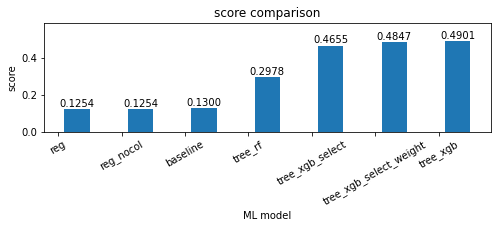

In [35]:
plot_user_metric(dic_results, 'score')

# time and computational complexity
This objective of this section is to simulate complexity of ML models used for this dataset. The ideal approach would be to check computational complexity using Big-O notation or picking different sizes of dataset to see how complexity changes. The absolute value itself can be misleading if we forget that it depends on computer power. Nevertheless, we can do a basic comparison from those models here. The final model should not be based only on score, but also on how long it takes to train, and, for real time applications, how long it takes to give a prediction. Other issues might also be important, such as interpretability, labor cost to build/tune the algorithm and ease of deployment.

#### Time comparison during training

In [36]:
dic_time = {}
for key,val in ml_dict.items():
    ml_model = re.sub('clf_.*_(.*)', r'\1', key)
    dic_time[ml_model] = val['train_time']

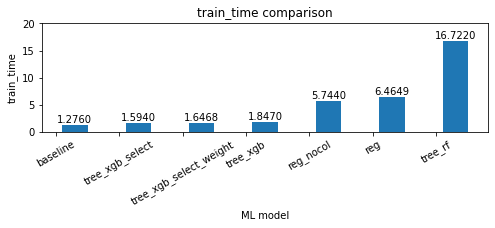

In [37]:
plot_user_metric(dic_time, 'train_time')

#### Time comparison during prediction

In [38]:
dic_pred = {}
for key,val in ml_dict.items():
    ml_model = re.sub('clf_.*_(.*)', r'\1', key)
    dic_pred[ml_model] = val['prediction_time']

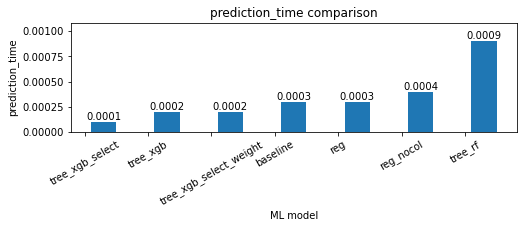

In [39]:
plot_user_metric(dic_pred, 'prediction_time')